In [1]:
from spectrogram import Spectrogram

import matplotlib.pyplot as plt
import numpy as np
import os
from peak_follower import PeakFollower
from jsonDriver import JsonReadDriver #These two driver classes enable reading and writing to JSON files easier
from jsonDriver import JsonWriteDriver
import datetime
import cv2
import argparse

# Files on which pipeline will be run
Here is the directory in which we will direct the pipeline.
It will read in these two sample files.

## Dig file structure

In [2]:
ls dig/pipeline

seg02.dig  seg03.dig


## Manual start JSON file structure
#The segements are from the file CH_1_009.json

In [3]:

myfile = open('pipeline_test.json')
print(myfile.read())
myfile.close()

{
  "File Category": "CH_1_009",
  "manual_starts": {
      "seg02.dig" : [8.74e-6,3000],
      "seg03.dig" : [7e-6, 2795],
      "seg04.dig" : [6.4e-6, 3000],
      "seg05.dig" : [6.8e-6, 2922],
      "seg06.dig" : [7.2e-6, 2800],
      "seg07.dig" : [7e-6, 2683],
      "seg09.dig" : [6.3e-6, 2829],
      "seg10.dig" : [6.7e-6, 2858],
      "seg11.dig" : [6e-6, 2916],
      "seg12.dig" : [7.56e-6, 2800]
  }
    
  
}



# Pipeline command line usage
Below is the documentation generated by running `pipeline.py --help`, showing the meaning of each optional argument to the command.

In [4]:

parser = argparse.ArgumentParser()
parser.add_argument('--file_name',type=str,default=False)
parser.add_argument('--peak_follow', type = str,default = True)
parser.add_argument('--manual_start', type = bool, default = True)
parser.add_argument('-json_name',type = str, default = 'pipeline_test.json')
parser.add_argument('--velocity_cutoff', type = int, default = 10000)
parser.add_argument('--denoise', type=bool,default = False)
parser.add_argument('--colormap', type=str, default = 'viridis', help = "colormap")
parser.add_argument(
        '-f',
        '--file',
        help='Path for input file. First line should contain number of lines to search in'
    )
# parser.add_argument('--process_name',type=)
args = parser.parse_args()

In [5]:
#set the directories that the files will be read from and written to
directory = '/home/max/clinic/dig/pipeline/'
saveTo = '/home/max/clinic/dig/digImages/'

#make a new directory based on the current time and date
a = datetime.datetime.now()
time = ('%02d.%02d-%02d:%02d'%(a.month,a.day,a.hour,a.minute))
try:
    os.mkdir(saveTo + time + '/')
except FileExistsError:
    print("Directory already exists, storing in same directory")
newDirectory = saveTo + time + '/'

In [6]:
#create the class object that will be used to read in the JSON start times
jsondata = JsonReadDriver(args.json_name)

#Create the dictionary to store the succesful runs
jsonwriting = JsonWriteDriver(newDirectory+time+'.json')

In [7]:
def denoise(intensities):
    #convert to 8bit int
    max = np.amax(i)
    data = i/max
    data = data * 255
    data = data.astype(np.uint8)  

    #perform the denoising
    out = cv2.fastNlMeansDenoising(data,None,50,7,21)
    # h = 50, templateWindowSize = 7,searchWindowSize = 21 
    # h is the most relevant, it describes how agressively the algorithm will run
    # The none is for a pointer to a return variable. Setting it to None makes the  '=' statement work

    
    return out

The following code is the loop which contains processes each file. It has the following structure.
For each file in the directory:

    1) Generate the spectrogram
    2) Slice that spectrogram into the correct bounds forthe start and end points, and the upper velocity cuttoff
    3) If peak following is requested, call the peak follower object and plot the trace
    4) Plot the spectrogram as a colormesh in the same plot as the trace
    5) Save the plot as a .png image in the current saveTo directory
    6) Clear the plot to begin the next file in the directory

In [8]:
for filename in os.listdir(directory):
    if filename.endswith(".dig"):
        
        #generate the spectrogram
        spec = Spectrogram(directory+filename)
        t,v,i = spec.slice((spec.t_start,spec.t_end),(0,args.velocity_cutoff))
        
        #get manual start info if required
        if args.manual_start:
            start_coords = jsondata.getManualStart(filename)
        
        #perform denoising
        if args.denoise:
            i = denoise(i)
        
        #perform peak following
        if (args.peak_follow == True):
            print('running',args.peak_follow)
            peaks = PeakFollower(spec,start_coords)
            peaks.run()
            
            #generate plottable trace information
            trace_v = np.array(peaks.results['velocities'])
            trace_t = np.array(peaks.results['times'])
            jsonwriting.store_time_length(filename,trace_t.size)
            plt.plot(trace_t*1e6,trace_v,color = "red")
      
        #plotting the results
        plt.pcolormesh(t*1e6,v,i,cmap='binary')
        
        #saving the new figure
        plt.savefig(newDirectory + filename+'.png')
        plt.clf()




running True
running True


<Figure size 432x288 with 0 Axes>

In [9]:
#part of the JSON library, a function that ensures all JSON data is written to disk
jsonwriting.flush()
print("done")


done


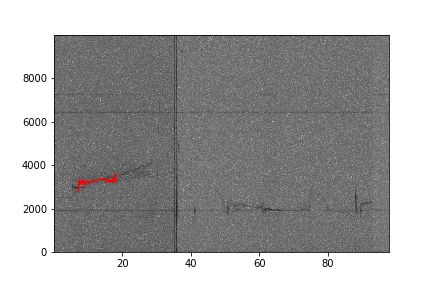

In [10]:
#This is the first file that we performed 
from IPython.display import Image
Image(filename=newDirectory+'seg03.dig.png') 

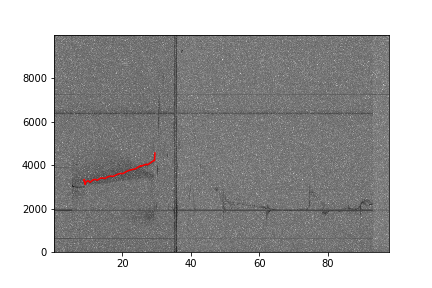

In [11]:
#The other image from this set
Image(filename=newDirectory+'seg02.dig.png') 

In [12]:
#This is what the 
myfile = open(newDirectory+time+'.json')
print(myfile.read())
myfile.close()
        

{
 "seg03.dig": 91,
 "seg02.dig": 170
}


# With denoising on
We will activate denoising by changing the args value, normally this would be done via the command line

In [13]:
args.denoise = True

In [14]:
for filename in os.listdir(directory):
    if filename.endswith(".dig"):
        
        #generate the spectrogram
        spec = Spectrogram(directory+filename)
        t,v,i = spec.slice((spec.t_start,spec.t_end),(0,args.velocity_cutoff))
        
        #get manual start info if required
        if args.manual_start:
            start_coords = jsondata.getManualStart(filename)
        
        #perform denoising
        if args.denoise:
            i = denoise(i)
        
        #perform peak following
        if (args.peak_follow == True):
            print('running',args.peak_follow)
            peaks = PeakFollower(spec,start_coords)
            peaks.run()
            
            #generate plottable trace information
            trace_v = np.array(peaks.results['velocities'])
            trace_t = np.array(peaks.results['times'])
            jsonwriting.store_time_length(filename,trace_t.size)
            plt.plot(trace_t*1e6,trace_v,color = "red")
      
        #plotting the results
        plt.pcolormesh(t*1e6,v,i,cmap='binary')
        
        #saving the new figure
        plt.savefig(newDirectory + filename+'.png')
        plt.clf()




running True
running True


<Figure size 432x288 with 0 Axes>

In [15]:
#part of the JSON library, a function that ensures all JSON data is written to disk
jsonwriting.flush()
print("done")


done


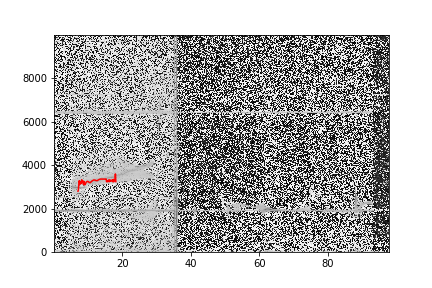

In [16]:
#This is the first file that we performed 
from IPython.display import Image
Image(filename=newDirectory+'seg03.dig.png') 

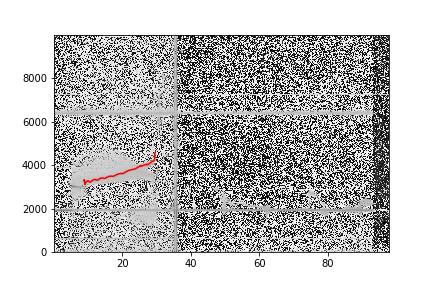

In [17]:
#The other image from this set
Image(filename=newDirectory+'seg02.dig.png') 

In [18]:
#This is what the 
myfile = open(newDirectory+time+'.json')
print(myfile.read())
myfile.close()
        

{
 "seg03.dig": 91,
 "seg02.dig": 170
}
